### Set Up

In [16]:
# import packages
import os 
from tqdm import tqdm
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import re
import torch
from transformers import BertTokenizer
import clip
import nltk
import string

from urllib import request
import urllib.request
import urllib.error
from concurrent.futures import ThreadPoolExecutor, as_completed

from PIL import Image
from torchvision import transforms

In [17]:
# load data
fakeddit = pd.read_csv('../data/multimodal_train.tsv', sep='\t')

In [18]:
len(fakeddit)

564000

In [19]:
# do 10% stratified subsampling of dataset
RANDOM_STATE = 42
df, df_backup = train_test_split(
    fakeddit,
    test_size=0.90,
    shuffle=True,
    stratify=fakeddit['3_way_label'],
    random_state=RANDOM_STATE
)

In [20]:
df.reset_index(drop=True, inplace=True)
len(df)

56400

### Data Exploration

In [21]:
df.head(5)

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,coryscalculator,yay for recycling,1.367963e+09,i.imgur.com,True,1dw0fk,https://external-preview.redd.it/SVpV2wF-Wzh4R...,NaN,0.0,6,pareidolia,Yay for recycling,0.81,0,2,2
1,50missioncap,yep theyre,1.462805e+09,NaN,True,d2ymcmj,http://i.imgur.com/oNLeh6A.jpg,4iif8d,NaN,2,psbattle_artwork,"Yep. They're 8""",NaN,0,2,4
2,yismeicha,casper the friendly coat,1.449010e+09,i.imgur.com,True,3v2a8d,https://external-preview.redd.it/annFO2AfFN7eV...,NaN,14.0,444,pareidolia,Casper the Friendly Coat,0.92,0,2,2
3,Touchstone033,bavarian bert,1.514869e+09,NaN,True,ds2gavx,https://i.imgur.com/hSEJSDX.jpg,7n8kwm,NaN,1,psbattle_artwork,colorized Bavarian Bert.,NaN,0,2,4
4,dannylenwinn,georgia governor signs restrictive heartbeat a...,1.557258e+09,apnews.com,True,blv8d1,https://external-preview.redd.it/E_n9-eE_xMhvO...,NaN,2.0,9,usnews,Georgia governor signs restrictive 'heartbeat'...,0.77,1,0,0


In [22]:
df.describe()

,created_utc,num_comments,score,upvote_ratio,2_way_label,3_way_label,6_way_label
count,5.640000e+04,39831.000000,56400.000000,39831.000000,56400.000000,56400.000000,56400.000000
mean,1.479419e+09,20.570561,409.084982,0.855867,0.393759,1.187926,1.873582
std,6.950619e+07,142.346025,3112.895577,0.110164,0.488587,0.969610,1.777388
min,1.216340e+09,0.000000,-128.000000,0.510000,0.000000,0.000000,0.000000
25%,1.419322e+09,1.000000,5.000000,0.780000,0.000000,0.000000,0.000000
50%,1.490200e+09,2.000000,14.000000,0.880000,0.000000,2.000000,2.000000
75%,1.550678e+09,7.000000,46.000000,0.940000,1.000000,2.000000,4.000000
max,1.571809e+09,7213.000000,91255.000000,1.000000,1.000000,2.000000,5.000000


In [23]:
df_check = df.drop(['author', 'clean_title', 'title',
                    'created_utc', 'linked_submission_id', 'id', 'image_url',
                    'num_comments', 'score', 'upvote_ratio'],
                    axis=1, inplace=False)
for col in df_check:
    print("Name of column:", col, "\nValues:", df_check[col].unique(), "\n")

Name of column: domain 
Values: ['i.imgur.com' nan 'apnews.com' ... 'eff.org' 'buzzednation.com'
 'thepunditpress.com'] 

Name of column: hasImage 
Values: [ True] 

Name of column: subreddit 
Values: ['pareidolia' 'psbattle_artwork' 'usnews' 'photoshopbattles'
 'mildlyinteresting' 'confusing_perspective' 'propagandaposters'
 'theonion' 'fakehistoryporn' 'upliftingnews' 'nottheonion'
 'fakealbumcovers' 'misleadingthumbnails' 'usanews' 'subredditsimulator'
 'savedyouaclick' 'waterfordwhispersnews' 'neutralnews' 'satire' 'pic'
 'subsimulatorgpt2' 'fakefacts'] 

Name of column: 2_way_label 
Values: [0 1] 

Name of column: 3_way_label 
Values: [2 0 1] 

Name of column: 6_way_label 
Values: [2 4 0 5 1 3] 



Since we will be using 3-way classification for our project, we will drop the label columns for 2-way and 6-way classification. 

In [24]:
df.drop(['2_way_label', '6_way_label'], axis=1, inplace=True)
df.head(5)

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,3_way_label
0,coryscalculator,yay for recycling,1.367963e+09,i.imgur.com,True,1dw0fk,https://external-preview.redd.it/SVpV2wF-Wzh4R...,NaN,0.0,6,pareidolia,Yay for recycling,0.81,2
1,50missioncap,yep theyre,1.462805e+09,NaN,True,d2ymcmj,http://i.imgur.com/oNLeh6A.jpg,4iif8d,NaN,2,psbattle_artwork,"Yep. They're 8""",NaN,2
2,yismeicha,casper the friendly coat,1.449010e+09,i.imgur.com,True,3v2a8d,https://external-preview.redd.it/annFO2AfFN7eV...,NaN,14.0,444,pareidolia,Casper the Friendly Coat,0.92,2
3,Touchstone033,bavarian bert,1.514869e+09,NaN,True,ds2gavx,https://i.imgur.com/hSEJSDX.jpg,7n8kwm,NaN,1,psbattle_artwork,colorized Bavarian Bert.,NaN,2
4,dannylenwinn,georgia governor signs restrictive heartbeat a...,1.557258e+09,apnews.com,True,blv8d1,https://external-preview.redd.it/E_n9-eE_xMhvO...,NaN,2.0,9,usnews,Georgia governor signs restrictive 'heartbeat'...,0.77,0


In [25]:
# make a copy of df
df_clean = df.copy()

In [26]:
# replace NaN values with empty strings
df_clean = df_clean.replace(np.nan, '', regex=True)
df_clean.fillna('', inplace=True)

# download images
def download_image(row, save_dir='../data/images/'):
    image_url = row['image_url']
    image_id = row['id']
    path = save_dir + image_id + '.jpg'

    if row['hasImage'] and image_url not in ['', 'nan']:
        try:
            with urllib.request.urlopen(image_url, timeout=10) as response:
                with open(path, 'wb') as f:
                    f.write(response.read())
            return None         # success
        except Exception as e:
            return row.name     # index of rows with invalid image_url
    return None

# parallel download
drop_indices = []
with ThreadPoolExecutor(max_workers=16) as executor:  
    futures = {executor.submit(download_image, row): idx for idx, row in df_clean.iterrows()}

    for i, future in enumerate(tqdm(as_completed(futures), total=len(futures))):
        idx = future.result()
        if idx is not None:
            drop_indices.append(idx)

df_clean.drop(index=drop_indices, inplace=True)
df_clean.reset_index(drop=True, inplace=True)

print("Downloaded all images.")

100%|██████████| 56400/56400 [29:48<00:00, 31.54it/s]  

Downloaded all images.


In [27]:
# from inspection, some image files are empty
# drop rows with empty/corrupted image files
def drop_empty_images(df, directory='../data/images/'):

    empty_files = []
    drop_indices = []

    for idx, row in df.iterrows():
        image_path = directory + row['id'] + '.jpg'
        try:
            with Image.open(image_path) as img:
                img.verify()
        except:
            empty_files.append(image_path)
            drop_indices.append(idx)
            # delete empty file
            if os.path.exists(image_path):
                os.remove(image_path)
        
    df.drop(index=drop_indices, axis=0, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return empty_files

empty_images = drop_empty_images(df_clean)
if empty_images:
    print(f"Found {len(empty_images)} empty images.")
else:
    print('All images are valid.')

Found 168 empty images.


(535, 320, 3)


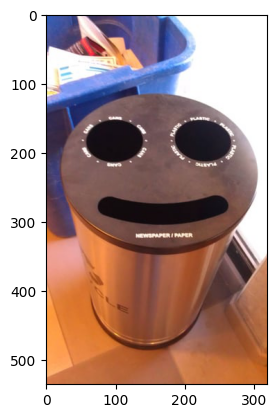

(426, 320, 3)


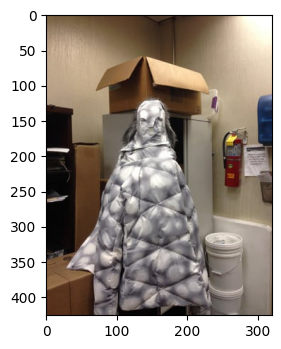

(257, 320, 3)


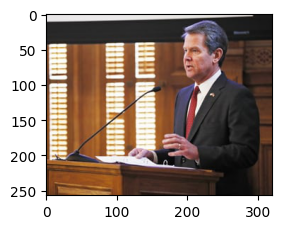

(399, 320, 3)


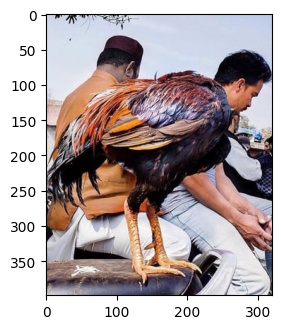

(240, 320, 3)


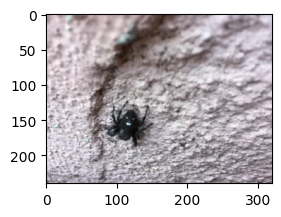

In [28]:
# test plot images
for i in range(5):
    path = '../data/images/' + df_clean['id'].iloc[i] + '.jpg'
    im = np.array(Image.open(path))

    print(im.shape)
    ax = plt.subplot(121)
    ax.imshow(im)
    plt.show()

We will perform train-validation-test split before preprocessing the data as preprocessing before splitting can cause the test set to implicitly learn from information in the training set, leading to an overly optimistic performance estimate. 

In [29]:
# train-val-test split of 80-10-10
RANDOM_STATE = 42
train_df, temp_df = train_test_split(
    df_clean,
    test_size=0.20,
    shuffle=True,
    stratify=df_clean['3_way_label'],
    random_state=RANDOM_STATE
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    shuffle=True,
    stratify=temp_df['3_way_label'],
    random_state=RANDOM_STATE
)

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print(f'Train size: {len(train_df)}')
print(f'Validation size: {len(val_df)}')
print(f'Test size: {len(test_df)}')

# checking class balance in splits
print("Label distribution (train):")
print(train_df["3_way_label"].value_counts(normalize=True))
print("Label distribution (validation):")
print(val_df["3_way_label"].value_counts(normalize=True))
print("Label distribution (test):")
print(test_df["3_way_label"].value_counts(normalize=True))

Train size: 30172
Validation size: 3772
Test size: 3772
Label distribution (train):
3_way_label
0    0.551770
2    0.412303
1    0.035927
Name: proportion, dtype: float64
Label distribution (validation):
3_way_label
0    0.551697
2    0.412513
1    0.035790
Name: proportion, dtype: float64
Label distribution (test):
3_way_label
0    0.551697
2    0.412248
1    0.036055
Name: proportion, dtype: float64


In [30]:
# class weighting: due to class imbalance
y_train = train_df['3_way_label']

classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)

print("Class weights:", class_weights)

# to use this as loss later
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

Class weights: tensor([0.6041, 9.2780, 0.8085])


### Data Preprocessing

#### Image Preprocessing

The images are of different sizes. Hence, we will resize all images to (224, 224, 3) for embedding and modelling.

In [31]:
# resizing pipeline
resize = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224)
])

save_dir = '../data/images/'

# resize images to (224, 224, 3)
def resize_image(image_id):
    path = save_dir + image_id + '.jpg'
    try:
        with Image.open(path) as img:
            img = img.convert("RGB")
            resized = resize(img)
            resized.save(path)
        return None
    except Exception as e:
        return image_id  # return failed image id

# parallel resizing for all dfs
all_dfs = {
    'Train': train_df,
    'Validation': val_df,
    'Test': test_df
}

for set, df in all_dfs.items():

    print(f"Resizing {set} dataset...")

    image_ids = df['id'].tolist()
    failed = []

    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = [executor.submit(resize_image, img_id) for img_id in image_ids]

        for future in tqdm(as_completed(futures), total=len(futures)):
            result = future.result()
            if result is not None:
                failed.append(result)

    print(f"Resized all images. Failed: {len(failed)}")

Resizing Train dataset...


  1%|          | 178/30172 [00:00<00:33, 902.54it/s]/Applications/anaconda3/envs/torch_env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 30172/30172 [00:51<00:00, 588.60it/s]


Resized all images. Failed: 0
Resizing Validation dataset...


100%|██████████| 3772/3772 [00:06<00:00, 565.99it/s]


Resized all images. Failed: 0
Resizing Test dataset...


100%|██████████| 3772/3772 [00:07<00:00, 516.16it/s]

Resized all images. Failed: 0


(224, 224, 3)


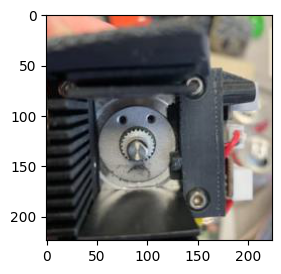

(224, 224, 3)


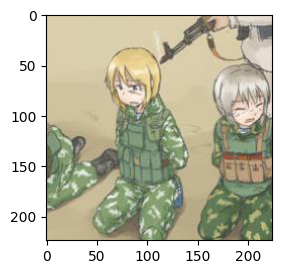

(224, 224, 3)


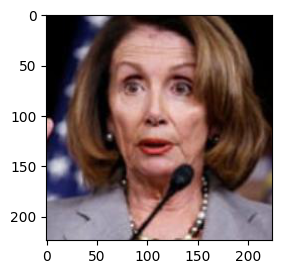

(224, 224, 3)


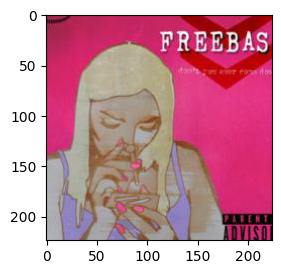

(224, 224, 3)


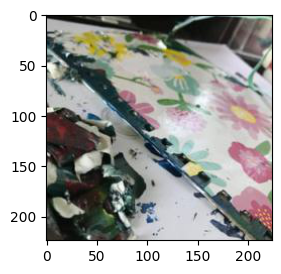

In [32]:
# test plot resized images
for i in range(5):
    path = '../data/images/' + train_df['id'].iloc[i] + '.jpg'
    im = np.array(Image.open(path))

    print(im.shape)
    ax = plt.subplot(121)
    ax.imshow(im)
    plt.show()

#### Text Preprocessing

Dataset contains a clean_title column. The original text column was cleaned using the following steps:
* Remove all punctuation, numbers, words that reveal the subreddit source

* Converted all text to lowercase

Hence, we will not be repeating the above steps again.

In [33]:
# drop `title` column since we will use `clean_title` column
train_df.drop(['title'], axis=1, inplace=True)
val_df.drop(['title'], axis=1, inplace=True)
test_df.drop(['title'], axis=1, inplace=True)

In [34]:
print(len(train_df))
train_df.head(5)

30172


,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,upvote_ratio,3_way_label
0,thefpsguy17,the inside of this d printer looks disappointed,1.553911e+09,i.redd.it,True,b75szp,https://preview.redd.it/7110qyxwy5p21.jpg?widt...,,0.0,9,pareidolia,0.91,2
1,fragments_from_Work,soviet vdv paratroopers executed by afghan muj...,1.495940e+09,i.imgur.com,True,6drlw0,https://external-preview.redd.it/hTQwQ0R85Xeie...,,0.0,6,fakehistoryporn,0.75,2
2,Twirrim,idaho teacher investigated for saying vagina d...,1.364421e+09,rawstory.com,True,1b4xs4,https://external-preview.redd.it/lPuC47UvGSfd6...,,18.0,317,nottheonion,0.97,0
3,sresendes73,freebase dont you ever come down,1.524703e+09,i.redd.it,True,8eyjt8,https://preview.redd.it/dmahex29e5u01.jpg?widt...,,2.0,8,fakealbumcovers,0.9,2
4,AdorkableBez,two layers of paint peeled off of a flat surface,1.559597e+09,i.redd.it,True,bwg9yl,https://preview.redd.it/2hu7qn1ul7231.jpg?widt...,,0.0,2,mildlyinteresting,0.75,0


In [35]:
# save clean datasets
train_df.to_csv('../data/fakeddit_train.tsv', sep='\t', index=False)
val_df.to_csv('../data/fakeddit_val.tsv', sep='\t', index=False)
test_df.to_csv('../data/fakeddit_test.tsv', sep='\t', index=False)

In [37]:
# tokenize titles for BERT and CLIP
def tokenize_titles(df, column_name='clean_title', max_length=256, device='cpu'):

    titles = df[column_name].astype(str).tolist()

    # use BERT tokenizer
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_encoded = bert_tokenizer(
        titles,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

    # use CLIP tokenizer
    clip_model, _ = clip.load('ViT-B/32', device=device)
    clip_tokens = clip.tokenize(titles).to(device)

    return df, bert_encoded, clip_tokens

# tokenize for train, validation and test sets
train_df, train_bert_tokens, train_clip_tokens = tokenize_titles(train_df)
val_df, val_bert_tokens, val_clip_tokens = tokenize_titles(val_df)
test_df, test_bert_tokens, test_clip_tokens = tokenize_titles(test_df)

AttributeError: module 'clip' has no attribute 'load'

### Exploratory Data Analysis (EDA)

#### Check class distribution

**3-way classification**
* 0: True (completely true sample)

* 1: Misleading (fake sample with some true text)

* 2: Fake (fake sample with fake text)

Since the dataset is highly imbalanced, we will incorporate class weights into the Cross Entropy Loss when training our models to account for class imbalance. 

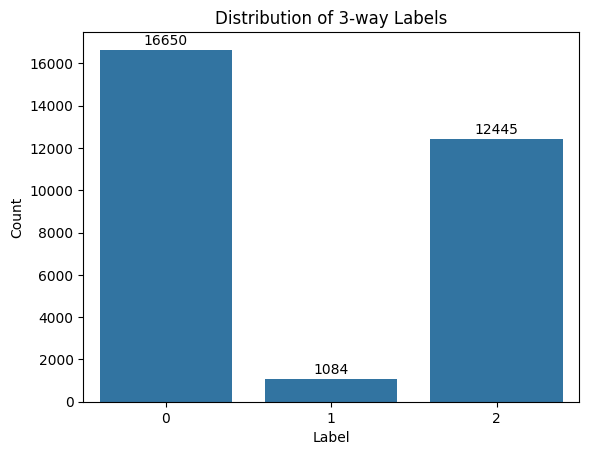

In [ ]:
# check class balance
counts = train_df['3_way_label'].value_counts().sort_index()

ax = sns.barplot(x=counts.index, y=counts.values)
for i, count in enumerate(counts.values):
    ax.text(i, count + 250, str(count), ha='center')
plt.title("Distribution of 3-way Labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

#### Visualise samples for each class in train set

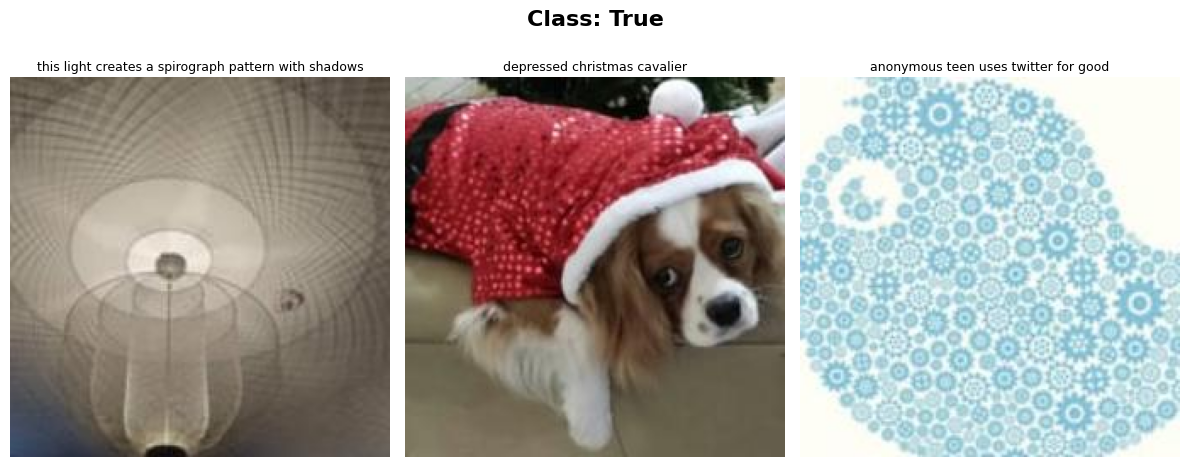

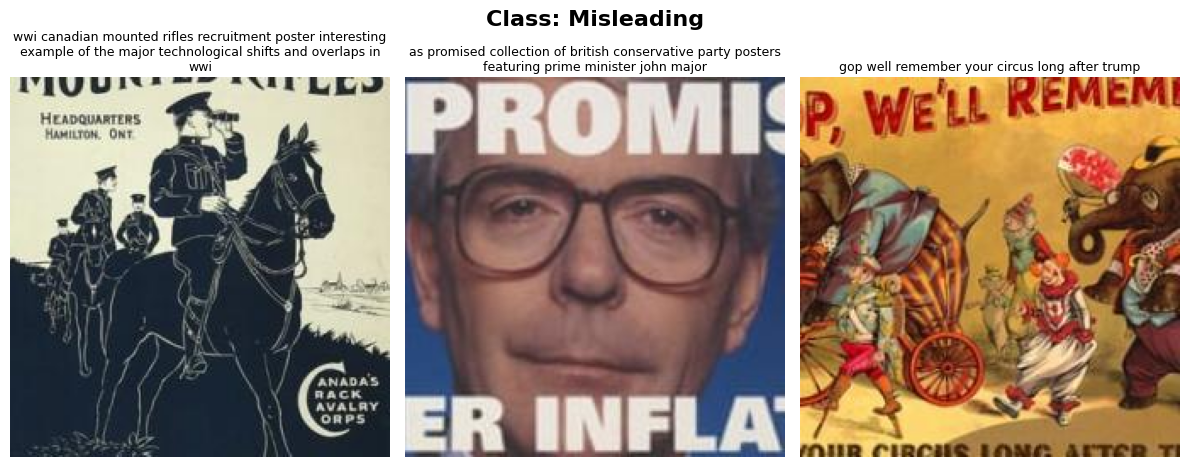

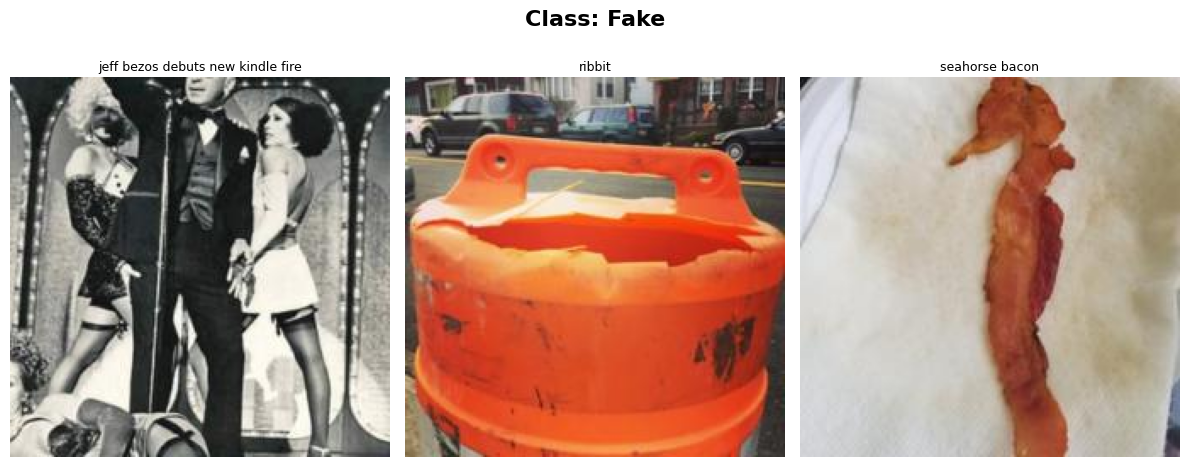

In [ ]:
# mapping labels to names
label_map = {
    0: "True",
    1: "Misleading",
    2: "Fake"
}

n_samples = 3

for cls in [0, 1, 2]:

    # filter first n samples for the class
    subset = train_df[train_df['3_way_label'] == cls].iloc[:n_samples]
    sample_ids = subset['id'].tolist()
    sample_texts = subset['clean_title'].tolist()   

    fig, ax = plt.subplots(1, n_samples, figsize=(12, 5))

    for col, (img_id, text) in enumerate(zip(sample_ids, sample_texts)):
        path = f"../data/images/{img_id}.jpg"
        
        try:
            # show image
            im = np.array(Image.open(path))
            ax[col].imshow(im)
            ax[col].axis("off")

            # show corresponding title
            wrapped_text = "\n".join(textwrap.wrap(text, width=60))
            ax[col].set_title(wrapped_text, fontsize=9, pad=5, loc="center")
            ax[col].title.set_position([0.5, -0.25])

        except:
            ax[col].axis("off")
            ax[col].set_title("Missing", fontsize=10, pad=5)
            ax[col].title.set_position([0.5, -0.25])
    
    fig.suptitle(f"Class: {label_map[cls]}", fontsize=16, weight="bold")
    plt.tight_layout()
    plt.show()


#### Visualise most common words for each class